In [209]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

mimic3_path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir), 'data')

In [210]:
# preprocessing functions
# nan values are assigned the privileged class
def get_religion_category(religion):
    if (religion == "JEWISH") or (religion == "OTHER") or (religion == "BUDDHIST") or (religion == "MUSLIM") or (religion == "HINDU") or (religion == "HEBREW"):
        return 0  # unprivileged
    return 1  # privileged

def get_language_category(lang):
    if (lang == "ENGL") or pd.isna(lang):
        return 1  # privileged
    return 0  # unprivileged

def get_age(df):
    adm.ADMITTIME = pd.to_datetime(adm.ADMITTIME).dt.date
    adm.DOB = pd.to_datetime(adm.DOB).dt.date
    adm['AGE'] = adm.apply(lambda e:int((e.ADMITTIME - e.DOB).days/365.242), axis=1)
    adm.loc[adm.AGE <= 0, 'AGE'] = 90
    adm.loc[adm.AGE >= 300, 'AGE'] = 90
    return df

def get_age_category(age):
    if age<65 or pd.isna(age):
        return 1  # privileged <65 plus nans
    return 0  # unprivileged 65+

def get_insurance_category(insurance):
    # considers government insurance in unprivileged class
    # if insurance == "Private" or pd.isna(insurance):
    #     return 1  # privileged
    # return 0  # unprivileged

    # considers only uninsured in unprivileged class
    if insurance == "Self Pay":
        return 0
    return 1

def get_ethnicity_category(ethnicity):
    if ("WHITE" in ethnicity) or (pd.isna(ethnicity)):
        return 1  # privileged
    return 0  # unprivileged

In [211]:
patients = pd.read_csv(os.path.join(mimic3_path, 'PATIENTS.csv'))
adm = pd.read_csv(os.path.join(mimic3_path, 'ADMISSIONS.csv'))

In [212]:
# keep only necessary columns
patients = patients[['SUBJECT_ID', 'GENDER', 'DOB']]
adm = adm[['SUBJECT_ID', 'LANGUAGE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'ADMITTIME']]

In [213]:
patients.head(100)

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13 00:00:00
1,250,F,2164-12-27 00:00:00
2,251,M,2090-03-15 00:00:00
3,252,M,2078-03-06 00:00:00
4,253,F,2089-11-26 00:00:00
...,...,...,...
95,744,M,2024-05-24 00:00:00
96,745,M,2142-06-14 00:00:00
97,746,M,2085-06-02 00:00:00
98,747,M,2063-03-10 00:00:00


In [214]:
adm.head(100)

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,ADMITTIME
0,22,NaN,Private,UNOBTAINABLE,WHITE,2196-04-09 12:26:00
1,23,NaN,Medicare,CATHOLIC,WHITE,2153-09-03 07:15:00
2,23,ENGL,Medicare,CATHOLIC,WHITE,2157-10-18 19:34:00
3,24,NaN,Private,PROTESTANT QUAKER,WHITE,2139-06-06 16:14:00
4,25,NaN,Private,UNOBTAINABLE,WHITE,2160-11-02 02:06:00
...,...,...,...,...,...,...
95,91,NaN,Medicare,JEWISH,WHITE,2177-04-23 00:08:00
96,92,NaN,Medicaid,UNOBTAINABLE,WHITE,2122-12-13 19:30:00
97,93,NaN,Private,CATHOLIC,WHITE,2128-03-17 17:11:00
98,94,CANT,Medicare,NOT SPECIFIED,ASIAN,2176-02-25 16:49:00


In [215]:
patients_original = patients.copy()
adm_original = adm.copy()

In [216]:
# merge the two tables
adm = adm.merge(patients, how='left', on='SUBJECT_ID')

In [217]:
# preprocess religion to christian (majority religion) vs. non-christian
# unknown values get the majority class
print("Original Religion Values:")
print(adm.RELIGION.value_counts())
adm.RELIGION = adm.RELIGION.apply(lambda religion: get_religion_category(religion))
print("Binarized Religion Values:")
print(adm.RELIGION.value_counts())

Original Religion Values:
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64
Binarized Religion Values:
1    50345
0     8631
Name: RELIGION, dtype: int64


In [218]:
# preprocess language to english (majority speaking) vs. non-english
# unknown values get the majority class
print("Original Language Values:")
print(adm.LANGUAGE.value_counts())
adm.LANGUAGE =adm.LANGUAGE.apply(lambda lang: get_language_category(lang))
print("Binarized Language Values:")
print(adm.LANGUAGE.value_counts())

Original Language Values:
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CANT      413
        ...  
* FU        1
*SPA        1
*RUS        1
*ROM        1
*TAM        1
Name: LANGUAGE, Length: 75, dtype: int64
Binarized Language Values:
1    54418
0     4558
Name: LANGUAGE, dtype: int64


Original Age Values:
90    10726
78     1139
77     1115
69     1096
76     1086
      ...  
17       69
16       23
15        8
14        1
89        1
Name: AGE, Length: 77, dtype: int64
Binarized Age Values:
0    34156
1    24820
Name: AGE, dtype: int64


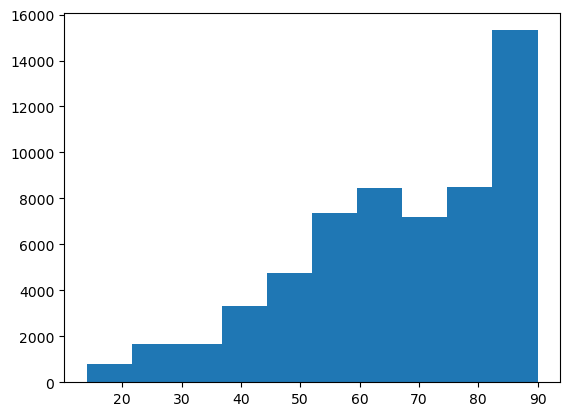

In [219]:
# preprocess age to 65+ (minority) vs younger
adm = get_age(adm)
plt.hist(adm.AGE)
print("Original Age Values:")
print(adm.AGE.value_counts())
adm.AGE =adm.AGE.apply(lambda age: get_age_category(age))
print("Binarized Age Values:")
print(adm.AGE.value_counts())

In [220]:
print("Original Insurance Values:")
print(adm.INSURANCE.value_counts())
adm.INSURANCE =adm.INSURANCE.apply(lambda insurance: get_insurance_category(insurance))
print("Binarized Insurance Values:")
print(adm.INSURANCE.value_counts())

Original Insurance Values:
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64
Binarized Insurance Values:
1    58365
0      611
Name: INSURANCE, dtype: int64


In [221]:
print("Original Ethnicity Values:")
print(adm.ETHNICITY.value_counts())
adm.ETHNICITY =adm.ETHNICITY.apply(lambda ethnicity: get_ethnicity_category(ethnicity))
print("Binarized Ethnicity Values:")
print(adm.ETHNICITY.value_counts())

Original Ethnicity Values:
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                             

In [222]:
adm.GENDER = adm.GENDER.apply(lambda gender: 0 if gender == "F" else 1)

In [223]:
adm.drop(['ADMITTIME', 'DOB'], axis=1, inplace=True)
print("Records w/ duplicates per user: {}".format(adm.shape[0]))
adm.drop_duplicates(subset=['SUBJECT_ID'], keep='last', inplace=True)  # keep the latest demographics per user
print("Records w/0 duplicates per user: {}".format(adm.shape[0]))

Records w/ duplicates per user: 58976
Records w/0 duplicates per user: 46520


In [224]:
adm.head(100)

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,22,1,1,1,1,0,1
2,23,1,1,1,1,1,0
3,24,1,1,1,1,1,1
4,25,1,1,1,1,1,1
5,26,1,1,1,0,1,0
...,...,...,...,...,...,...,...
116,107,1,1,1,0,1,0
117,108,1,1,1,1,1,0
131,125,0,1,1,0,0,1
132,126,1,1,1,1,0,0


In [225]:
adm.to_csv(os.path.join(mimic3_path, 'DEMOGRAPHICS.csv'), index=False)
print("Demographics file saved at: {}".format(os.path.join(mimic3_path, 'DEMOGRAPHICS.csv')))

Demographics file saved at: C:\Users\Sofia\PycharmProjects\mimic3-benchmarks\data\DEMOGRAPHICS.csv
